In [1]:
import os
import random
import warnings
from typing import Tuple

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)


warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=anndata._core.views.ImplicitModificationWarning)



In [2]:
def classifier_knn(
        x: np.ndarray, y: np.ndarray, neighbor_frac: float = 0.01, test_size: float = 0.8, **kwargs
) -> float:
    k = max(round(y.shape[0] * neighbor_frac), 1)
    DATA_tr, DATA_te, tr_LABEL, te_LABEL = train_test_split(x, y, test_size=test_size, random_state=42)
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(DATA_tr, tr_LABEL)
    L_pred = clf.predict(x)
    return L_pred

def jaccard(first, second):
    # Check and convert first input
    if isinstance(first, set):
        first_set = first
    elif isinstance(first, pd.Index):
        first_set = set(first) if not first.empty else set()
    elif isinstance(first, list):
        first_set = set(first) if len(first) else set()
    else:
        first_set = set()

    # Check and convert second input
    if isinstance(second, set):
        second_set = second
    elif isinstance(second, pd.Index):
        second_set = set(second) if not second.empty else set()
    elif isinstance(second, list):
        second_set = set(second) if len(second) else set()
    else:
        second_set = set()
    # Check if both indices are empty
    if not first_set and not second_set:
        # Handle the case where both sets are empty
        # Return 1 or 0 based on your convention for similarity of empty sets
        return 1.0
    return len(first_set.intersection(second_set)) / len(first_set.union(second_set))


In [3]:
parent_dir = '/mnt/nas/user/yixuan/SCMBench/data/download'
latent_dir = '/mnt/nas/user/yixuan/SCMBench/results'

# datasets=['10x-Multiome-Pbmc10k-small', 'Chen-2019-small', 'Ma-2020-batch-53-small', 'Ma-2020-batch-54-small', 'Ma-2020-batch-55-small', 'Ma-2020-batch-56-small']
datasets=['10x-Multiome-Pbmc10k-small']
# datasets = os.listdir(parent_dir)
method = [
            'GLUE', 'LIGER', 'TotalVI', 'UnionCom',
            'scMoMaT', 'MMD_MA', 'Deepmaps',
            'bindsc', 'Cobolt', 'scMDC',
            'Pamona', 'PCA', 'scJoint', 'seurat4', 'seurat5',
            'iNMF', 'scVI', 'MOFA',
            'scGPT_bc','scGPT_human','scGPT_bc_zero','scGPT_human_zero',
            'UCE','Geneformer','scFoundation'
            ]
# method = [
#             'scGPT_bc','scGPT_human','scGPT_bc_zero','scGPT_human_zero',
#             'UCE','Geneformer','scFoundation'
#             ]
# method = [
#             'GLUE', 'LIGER', 'TotalVI', 'UnionCom',
#             'scMoMaT', 'MMD_MA', 'Deepmaps',
#             'bindsc', 'Cobolt', 'scMDC',
#             'Pamona', 'PCA', 'scJoint', 'seurat4', 'seurat5',
#             'iNMF', 'scVI', 'MOFA',
#             'UCE','scGPT'
#             ]


{'Memory B', 'CD8 Naive', 'Treg', 'MAIT', 'gdT', 'Naive B', 'cDC', 'CD4 TEM', 'CD8 TEM_1', 'CD4 Naive', 'CD14 Mono', 'CD8 TEM_2', 'CD4 TCM', 'NK', 'HSPC', 'pDC', 'CD16 Mono', 'Plasma', 'Intermediate B'}
Finish:  GLUE
Finish:  LIGER
Finish:  TotalVI
Finish:  UnionCom
Finish:  scMoMaT
Finish:  MMD_MA
Finish:  Deepmaps
Finish:  bindsc
Finish:  Cobolt
Finish:  scMDC
Finish:  Pamona
Finish:  PCA
Finish:  scJoint
Finish:  seurat4
Finish:  seurat5
Finish:  iNMF
Finish:  scVI
Finish:  MOFA
Finish:  scGPT_bc
Finish:  scGPT_human
Finish:  scGPT_bc_zero
Finish:  scGPT_human_zero
Finish:  UCE
Finish:  Geneformer
Finish:  scFoundation


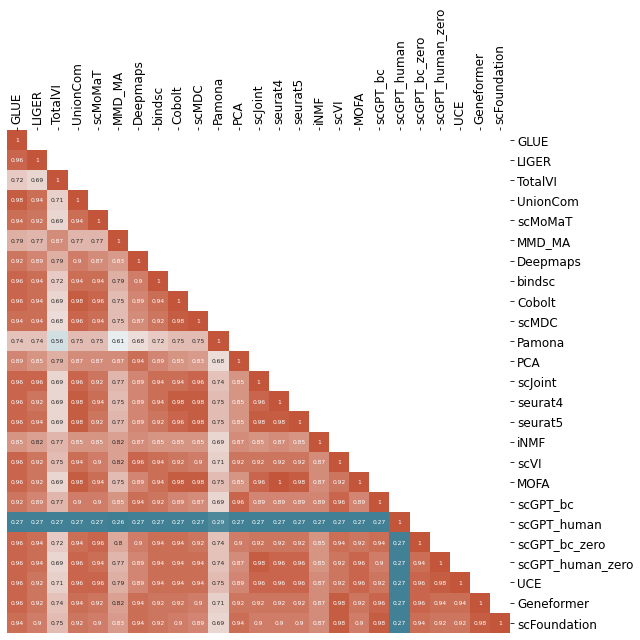

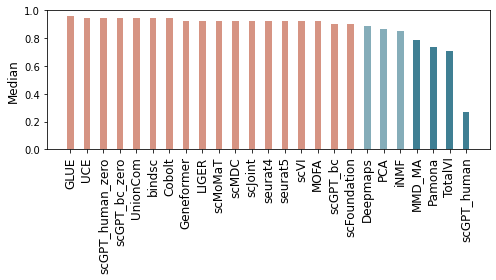

In [4]:

for dataset in datasets: 
    input_datasets = f'{parent_dir}/{dataset}/{dataset}-RNA.h5ad'
    data = anndata.read_h5ad(input_datasets)
    cell_type, domain, var = data.obs["cell_type"].to_numpy(), data.obs["domain"].to_numpy(), data.var_names
    uni = np.array(data.X.todense())
    cell_types_list = set(cell_type)
    print(cell_types_list)
    marker_dict = {}
    cell_types_list=['NK']

    for main_type in cell_types_list: 
        try: 
            for item in method:
                try: 
                    input_latent = f'{latent_dir}/{dataset}/{item}_rna.csv'
                    latent = pd.read_csv(input_latent, header=None, index_col=0).to_numpy()
                    mask = ~np.isnan(latent).any(axis=1)
                    combined_latent = latent[mask]
                    predicted_cell_type = classifier_knn(combined_latent, cell_type[mask])

                    adata = sc.AnnData(X=uni[mask], obs={'domain': domain[mask], 'cell_type': cell_type[mask], 'predicted_cell_type': predicted_cell_type}, var=var.to_frame(index=False))
                    sc.pp.normalize_total(adata)
                    sc.pp.log1p(adata)
                    sc.pp.highly_variable_genes(adata, n_top_genes=5000, flavor="seurat")
                    adata = adata[:, adata.var.highly_variable]

                    adata.obs['predicted_cell_type'] = np.array(predicted_cell_type)

                    try: 
                        if main_type not in adata.obs['predicted_cell_type'].unique():
                            print(f"Error: '{main_type}' not present in 'predicted_cell_type'")
                            marker_dict[item] = set()
                        else:
                            # Only proceed if main_type is present
                            sc.tl.rank_genes_groups(
                                adata, 
                                groupby = 'predicted_cell_type', 
                                groups = [main_type],
                                method = 't-test',
                                n_genes = 100,
                            )

                            md = ( 
                                sc.get.rank_genes_groups_df(adata, group=main_type) 
                                .set_index('names', drop=True) 
                            ) 
                            marker_dict[item] = md.index
                    except ValueError:
                        print("Value error, skip and continue")
                        continue
                except FileNotFoundError:
                    print("File not found, skip and continue")
                print("Finish: ", item)
        
            # os.makedirs(f'/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/graphs/{dataset}', exist_ok=True)
            # np.save(f'/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/graphs/{dataset}/marker_dict_{main_type}.npy', marker_dict)

            keys = list(marker_dict.keys())
            result_dict = {}

            for k in keys:
                for l in keys:
                    result_dict[(k,l)] = marker_dict.get((l,k), jaccard(marker_dict[k], marker_dict[l]))

            data = np.array(list(result_dict.values()) ).reshape(len(keys),len(keys))
            # np.save(f'/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/graphs/{dataset}/np_jaccard_{main_type}.npy', data)

            methods = keys

            # Assuming 'data' and 'keys' variables are already defined
            mask = np.triu(np.ones_like(data, dtype=bool), k=+1)
            medians = np.median(data, axis=1)  # Calculate medians
            
            # np.save(f'/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/graphs/{dataset}/np_median_{main_type}.npy', medians)

            # Sorting medians and keys from high to low
            sorted_indices = np.argsort(medians)[::-1]
            sorted_medians = medians[sorted_indices]
            sorted_keys = np.array(keys)[sorted_indices]

            # Plotting the heatmap separately
            fig, ax = plt.subplots(figsize=(9, 9))
            sns.heatmap(data, mask=mask, annot=True, annot_kws={"fontsize": 6}, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax, cbar=False)
            ax.xaxis.tick_top()
            ax.set_xticklabels(marker_dict.keys(), rotation=90, fontsize=12)
            ax.yaxis.tick_right()
            ax.set_yticklabels(marker_dict.keys(), rotation=0, fontsize=12)
            plt.tight_layout()
            # plt.savefig(f'/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/graphs/{dataset}/{main_type}_heatmap.pdf', transparent=True)

            # Plotting the sorted histogram separately with color coding
            fig, ax = plt.subplots(figsize=(7, 4))
            bar_width = 0.4
            x = np.arange(len(sorted_keys))

            # Color coding based on intervals
            for i, median in enumerate(sorted_medians):
                color = sns.diverging_palette(220, 20)[4] if median >= 0.9 else (sns.diverging_palette(220, 20)[1] if median >= 0.8 else sns.diverging_palette(220, 20)[0])
                ax.bar(i, median, width=bar_width, color=color)

            ax.set_xticks(x)
            ax.set_xticklabels(sorted_keys, rotation=90, fontsize=12)
            ax.set_ylim(0, 1)
            ax.set_ylabel('Median', fontsize=12)  # Label changed to 'Median'
            plt.tight_layout()
            # plt.savefig(f'/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/graphs/{dataset}/{main_type}_histogram.pdf', transparent=True)
        except FileNotFoundError:
            continue